In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from wordcloud import WordCloud
nltk.download("stopwords")
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.layers import Dropout


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karmi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\karmi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [3]:
print("Null Values\n",data.isnull().sum())
print("\nData Shape: " , data.shape)

Null Values
 is_sarcastic    0
headline        0
article_link    0
dtype: int64

Data Shape:  (28619, 3)


In [4]:
def find_num_words(data):
    wordlist = []
    splitting_list = data.str.split()
    for i in range(len(splitting_list)):
        for j in range(len(splitting_list[i])):
            wordlist.append(splitting_list[i][j])

    wordset = set(wordlist)

    print(len(wordset),len(wordlist))

find_num_words(data.headline)

38234 287620


In [5]:
def remove_punctuations(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_specialchars(text):
    return re.sub("[^a-zA-Z]"," ",text)

def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    text = nltk.word_tokenize(text)

    for word in text:
        if word not in set(stopwords.words('english')):
            lemma = nltk.WordNetLemmatizer()
            word = lemma.lemmatize(word)
            final_text.append(word)
    return " ".join(final_text)


def cleaning(text):
    text = remove_punctuations(text)
    text = remove_specialchars(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

data['headline']=data['headline'].apply(cleaning)

In [6]:
sentences = data["headline"].values.tolist()
target = data["is_sarcastic"].values.tolist()

In [7]:
num_words = 1000
tokenizer = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts(sentences)
tokens = tokenizer.texts_to_sequences(sentences)

numTokens = [len(token) for token in tokens]
numTokens = np.array(numTokens)
print("Tokens'mean",np.mean(numTokens))
print("Max", np.max(numTokens))
print("Argmax", np.argmax(numTokens))

Tokens'mean 3.743352318389881
Max 31
Argmax 7302


In [8]:
max_tokens = int(np.mean(numTokens) + 2*np.std(numTokens))
print("Calculated maximum number of tokens :",max_tokens)
print("What percentage of the data fits this average? :",np.sum(numTokens < max_tokens) / len(numTokens))

Calculated maximum number of tokens : 7
What percentage of the data fits this average? : 0.9100597505153919


In [9]:
padding_data = pad_sequences(tokens, maxlen=max_tokens)
print(padding_data.shape)
print(len(target))

(28619, 7)
28619


In [10]:
X_train, X_test, y_train, y_test = train_test_split(padding_data, data.is_sarcastic, random_state=1, test_size=0.15, stratify=data.is_sarcastic)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1, test_size=0.1, stratify=y_train)

{'l': 0.00012187982255310876, 'embedding_size': 10, 'batch_size': 16, 'epochs': 20, 'learning_rate': 3.839753364454998e-05, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>}

In [11]:
model = Sequential()
model.add(Embedding(input_dim = num_words,
                    output_dim=10,
                    input_length=max_tokens,
                    name='embedding_layer'))

model.add(GRU(units=64, return_sequences=True,kernel_regularizer = tf.keras.regularizers.l2(0.00012), dropout=0.2, recurrent_dropout=0.2))
model.add(GRU(units=32))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer=Adam(0.00004), loss='binary_crossentropy', metrics=['accuracy'])

H = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5213 - loss: 0.6941 - val_accuracy: 0.5236 - val_loss: 0.6904
Epoch 2/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5404 - loss: 0.6892 - val_accuracy: 0.6075 - val_loss: 0.6804
Epoch 3/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6117 - loss: 0.6748 - val_accuracy: 0.6691 - val_loss: 0.6502
Epoch 4/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6742 - loss: 0.6306 - val_accuracy: 0.7045 - val_loss: 0.5858
Epoch 5/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7075 - loss: 0.5695 - val_accuracy: 0.7213 - val_loss: 0.5558
Epoch 6/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7175 - loss: 0.5456 - val_accuracy: 0.7222 - val_loss: 0.5417
Epoch 7/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7327 - loss: 0.5297 - val_accuracy: 0.7213 - val_loss: 0.5365
Epoch 8/20
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7345 - loss: 0.5239 - val_accuracy: 0.

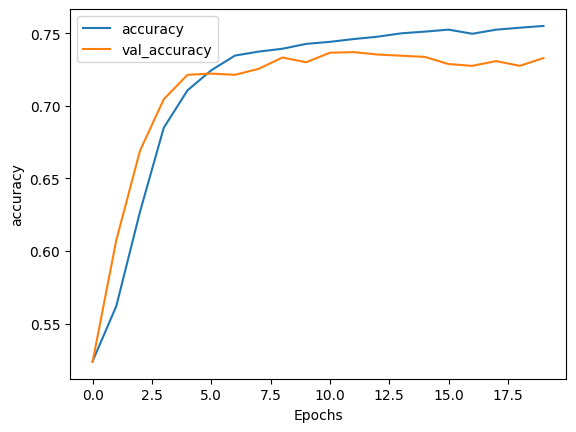

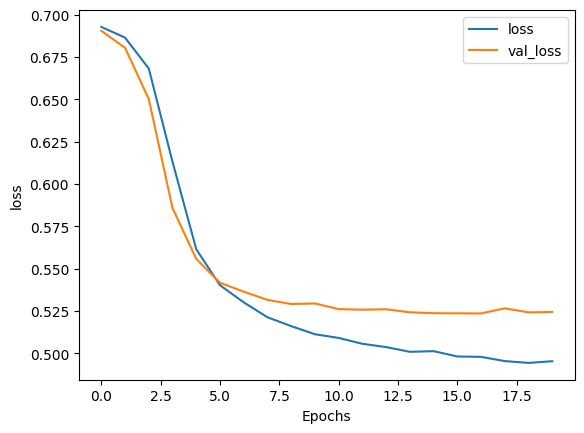

In [12]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(H.history[string])
    plt.plot(H.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(H, 'accuracy')
plot_graphs(H, 'loss')

In [13]:
def predict_sarcasm(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=max_tokens)
    pred_ind = int(model.predict(tw).round().item())
    if pred_ind == 1:
        prediction = "Sarcastic"
    else:
        prediction = "Not Sarcastic"
    print('Prediction: ', prediction)

In [14]:
with open('sarcastic.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        sentence = line.strip()
        predict_sarcasm(sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
Prediction:  Sarcastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediction:  Sarcastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediction:  Not Sarcastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction:  Sarcastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction:  Sarcastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediction:  Sarcastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction:  Sarcastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction:  Sarcastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediction:  Sarcastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction:  Sarcastic


In [15]:
with open('not_sarcastic.txt', 'r') as file:
    lines = file.readlines()
    for line in lines:
        sentence = line.strip()
        predict_sarcasm(sentence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction:  Not Sarcastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediction:  Sarcastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction:  Sarcastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction:  Sarcastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediction:  Not Sarcastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction:  Not Sarcastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction:  Not Sarcastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction:  Not Sarcastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Prediction:  Not Sarcastic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Prediction:  Not Sarcastic
